In [1]:
import scvi
import pandas as pd
import numpy as np
import scanpy as sc
import seaborn as sns
import torch

%config InlineBackend.print_figure_kwargs={"facecolor": "w"}
%config InlineBackend.figure_format="retina"

/home/share/huadjyin/home/ouyangkang/software/miniconda3/envs/sc/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/share/huadjyin/home/ouyangkang/software/miniconda3/envs/sc/lib/python3.12/site-packages/docrep/decorators.py:43: SyntaxWarning: 'param_categorical_covariate_keys' is not a valid key!
  doc = func(self, args[0].__doc__, *args[1:], **kwargs)
/home/share/huadjyin/home/ouyangkang/software/miniconda3/envs/sc/lib/python3.12/site-packages/docrep/decorators.py:43: SyntaxWarning: 'param_continuous_covariate_keys' is not a valid key!
  doc = func(self, args[0].__doc__, *args[1:], **kwargs)


In [2]:
scvi.settings.seed = 0
print("Last run with scvi-tools version:", scvi.__version__)

Seed set to 0


Last run with scvi-tools version: 1.3.0


In [3]:
# enhance calculated speed
torch.set_float32_matmul_precision("high")

In [4]:
print(torch.cuda.is_available())

True


In [5]:
ctc = sc.read_h5ad('/home/share/huadjyin/home/ouyangkang/project/ctc/data/raw/ctc_integrated_data_for_scVI.h5ad')

In [6]:
ctc

AnnData object with n_obs × n_vars = 23728 × 36472
    obs: 'total_counts', 'pct_counts_mt', 'pct_counts_rb', 'pct_counts_hb', 'n_genes', 'doublet_score', 'chip_id'
    var: 'n_cells'
    layers: 'counts'

In [7]:
ctc.obs.head()

total_counts  pct_counts_mt  pct_counts_rb  pct_counts_hb  \
730.0-Y00784ME_2        2955.0       5.583756       0.406091       0.033841   
753.0-Y00784ME_2        5802.0       2.257842       1.258187       0.000000   
327.0-Y00784ME_2        4449.0      10.092156       3.326590       0.000000   
333.0-Y00784ME_2        3549.0       9.664694       1.690617       0.000000   
648.0-Y00784ME_2        2649.0       6.908267       2.227256       0.000000   

                  n_genes  doublet_score     chip_id  
730.0-Y00784ME_2     1207       0.016181  Y00784ME_2  
753.0-Y00784ME_2     2026       0.022059  Y00784ME_2  
327.0-Y00784ME_2     1447       0.055901  Y00784ME_2  
333.0-Y00784ME_2     1341       0.018933  Y00784ME_2  
648.0-Y00784ME_2     1039       0.018933  Y00784ME_2

In [8]:
patient_info = {
    "C03427D3": "Patient_1",
    "C03427D4": "Patient_1",
    "A04086G2": "Patient_1",
    "A04230E4_15": "Patient_2",
    "A04088E3": "Patient_3",
    "A04086G3": "Patient_4",
    "A04227C4_13": "Patient_5",
    "A04228A4_1": "Patient_5",
    "A04227C4_14": "Patient_6",
    "A04230E4_16": "Patient_7",
    "A04229A3": "Patient_7",
    "A04232A3": "Patient_8",
    "Y00784ME_1": "Patient_9",
    "A04230E2": "Patient_10",
    "Y00723F2_1": "Patient_11",
    "Y00723F2_2": "Patient_12",
    "Y00784ME_2": "Patient_13",
    "A04224E3": "Healthy"
}

In [9]:
for i in patient_info.keys():
    if i not in ctc.obs['chip_id'].unique():
        print(i)

In [10]:
ctc.obs['patient_info'] = ctc.obs['chip_id'].replace(patient_info)

/tmp/ipykernel_1853762/2839682100.py:1: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  ctc.obs['patient_info'] = ctc.obs['chip_id'].replace(patient_info)


In [11]:
# V0: baseline
# V2: one or two monthes after chemoimmunotherapy
# S2: two weeks after surgical
phage_info = {
    "C03427D3": "V2",
    "C03427D4": "V2",
    "A04086G2": "S2",
    "A04230E4_15": "S2",
    "A04088E3": "S2",
    "A04086G3": "S2",
    "A04227C4_13": "V0",
    "A04228A4_1": "V2",
    "A04227C4_14": "S2",
    "A04230E4_16": "V0",
    "A04229A3": "V2",
    "A04232A3": "V2",
    "Y00784ME_1": "V2",
    "A04230E2": "V2",
    "Y00723F2_1": "S2",
    "Y00723F2_2": "V2",
    "Y00784ME_2": "S2",
    "A04224E3": "None"
}

In [12]:
ctc.obs['phage_info'] = ctc.obs['chip_id'].replace(phage_info)

/tmp/ipykernel_1853762/328371594.py:1: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  ctc.obs['phage_info'] = ctc.obs['chip_id'].replace(phage_info)


In [13]:
ctc.obs.head()

total_counts  pct_counts_mt  pct_counts_rb  pct_counts_hb  \
730.0-Y00784ME_2        2955.0       5.583756       0.406091       0.033841   
753.0-Y00784ME_2        5802.0       2.257842       1.258187       0.000000   
327.0-Y00784ME_2        4449.0      10.092156       3.326590       0.000000   
333.0-Y00784ME_2        3549.0       9.664694       1.690617       0.000000   
648.0-Y00784ME_2        2649.0       6.908267       2.227256       0.000000   

                  n_genes  doublet_score     chip_id patient_info phage_info  
730.0-Y00784ME_2     1207       0.016181  Y00784ME_2   Patient_13         S2  
753.0-Y00784ME_2     2026       0.022059  Y00784ME_2   Patient_13         S2  
327.0-Y00784ME_2     1447       0.055901  Y00784ME_2   Patient_13         S2  
333.0-Y00784ME_2     1341       0.018933  Y00784ME_2   Patient_13         S2  
648.0-Y00784ME_2     1039       0.018933  Y00784ME_2   Patient_13         S2

In [14]:
print(ctc.shape)
sc.pp.filter_cells(ctc, min_genes=300)
print(ctc.shape)

(23728, 36472)
(22834, 36472)


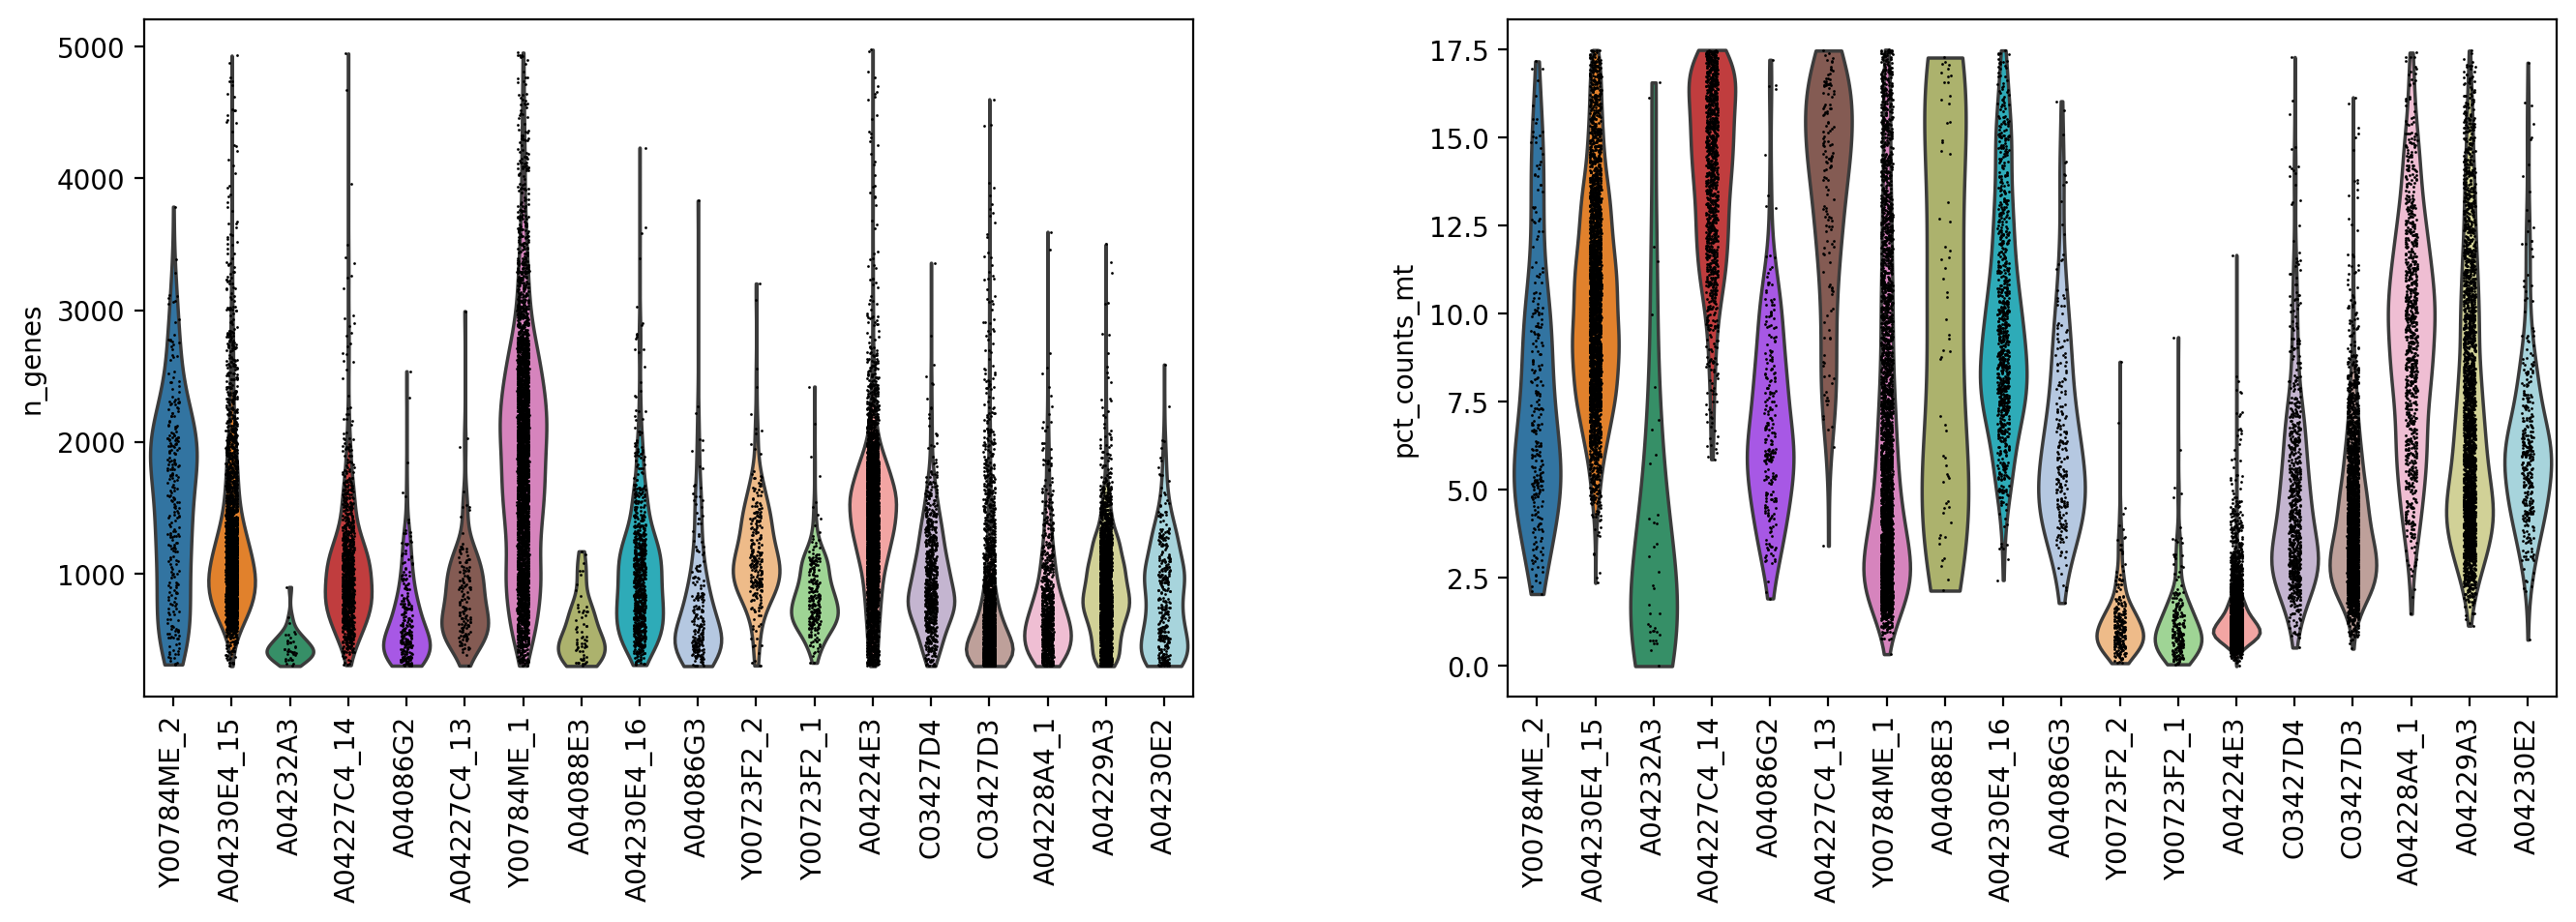

In [15]:
sc.pl.violin(ctc, ["n_genes", "pct_counts_mt"], groupby='chip_id', multi_panel=True, rotation=90)

In [16]:
# for data visualization
ctc.obs[['n_genes', 'pct_counts_mt', 'chip_id']].to_csv('data_quality.csv')

In [16]:
sc.pp.normalize_total(ctc, target_sum=1e4)
sc.pp.log1p(ctc)

In [17]:
ctc.raw = ctc

In [69]:
sc.pp.highly_variable_genes(
    ctc,
    flavor="seurat_v3",
    n_top_genes=1500,
    layer="counts",
    batch_key="chip_id",
    span=0.8
)

In [70]:
ctc

AnnData object with n_obs × n_vars = 22834 × 36472
    obs: 'total_counts', 'pct_counts_mt', 'pct_counts_rb', 'pct_counts_hb', 'n_genes', 'doublet_score', 'chip_id', 'patient_info', 'phage_info', '_scvi_batch', '_scvi_labels', 'leiden', 'anno'
    var: 'n_cells', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'highly_variable_nbatches'
    uns: 'chip_id_colors', 'log1p', 'hvg', '_scvi_uuid', '_scvi_manager_uuid', 'neighbors', 'leiden', 'umap', 'leiden_colors', 'anno_colors'
    obsm: '_scvi_extra_categorical_covs', '_scvi_extra_continuous_covs', 'X_scVI', 'X_umap'
    layers: 'counts'
    obsp: 'distances', 'connectivities'

In [71]:
scvi.model.SCVI.setup_anndata(
    ctc,
    layer="counts",
    categorical_covariate_keys=["chip_id", 'phage_info'],
    continuous_covariate_keys=["n_genes", "pct_counts_mt", 'doublet_score'],
)

In [72]:
model = scvi.model.SCVI(ctc)

In [73]:
model

SCVI model with the following parameters: 
n_hidden: 128, n_latent: 10, n_layers: 1, dropout_rate: 0.1, dispersion: gene, gene_likelihood: zinb, 
latent_distribution: normal.
Training status: Not Trained
Model's adata is minified?: False

In [74]:
model.train()

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/share/huadjyin/home/ouyangkang/software/miniconda3/envs/sc/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=127` in the `DataLoader` to improve performance.


Epoch 350/350: 100%|██████████| 350/350 [26:24<00:00,  4.55s/it, v_num=1, train_loss_step=4.97e+3, train_loss_epoch=4.68e+3]

`Trainer.fit` stopped: `max_epochs=350` reached.


Epoch 350/350: 100%|██████████| 350/350 [26:24<00:00,  4.53s/it, v_num=1, train_loss_step=4.97e+3, train_loss_epoch=4.68e+3]


<Axes: title={'center': 'Training Loss Curve'}, xlabel='Epoch', ylabel='Loss'>

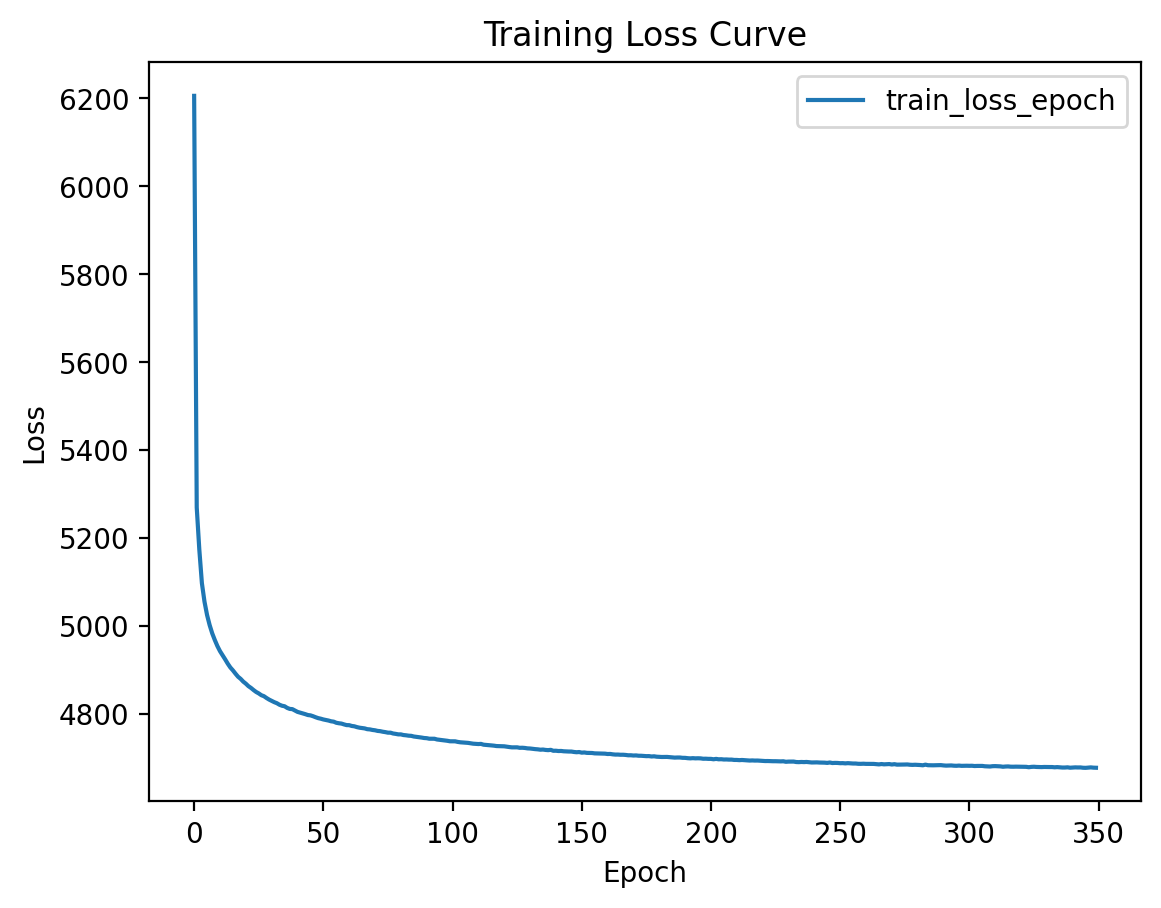

In [75]:
model.history['train_loss_epoch'].plot(title='Training Loss Curve', xlabel='Epoch', ylabel='Loss')

In [56]:
model.save('./scvi_for_CTC', overwrite=True)

In [76]:
SCVI_LATENT_KEY = "X_scVI"
ctc.obsm[SCVI_LATENT_KEY] = model.get_latent_representation()

In [77]:
sc.pp.neighbors(ctc, use_rep=SCVI_LATENT_KEY)
sc.tl.leiden(ctc, flavor='igraph', n_iterations=-1, resolution=0.8)

In [78]:
sc.tl.umap(ctc, min_dist=0.3, spread=1.75)

In [80]:
sc.tl.rank_genes_groups(ctc, "leiden", method="wilcoxon")

In [81]:
pd.DataFrame(ctc.uns["rank_genes_groups"]["names"]).head(150).to_csv("ctc_marker_genes.csv", index=None)

In [46]:
anno_mapping = {
    "0": "Monocyte", # 	A100A9, CYRIA, DUSP1, FCN1, LYZ2, PSAP, S100A8, VCAN, WARS
    "1": "T cell", # BCL11B, CAMK IV, FYB, IL-7R, LEF1, TCF7, TMEM66
    "2": "B cell", # BCL11A, CD79A, GNG7, PAX5, POU2AF1
    "3": "B cell", #  BACH2, BCL11A, CD22, GNG7, NIBAN3, PAX5
    "4": "Doublet", # CD2, CX3CR1, FCG3RA, FGFBP2, GNLY, GZMA, GZMB, KLRB1, NKG7, PRF1
    "5": "NK cell", # CD247, GNLY, GZMA, GZMB, KLRB1, KLRD1, KLRF1, NKG7, PRF1, SPON2
    "6": "T cell", # BCL11B, CAMK IV, CD6, FYB, IL-7R, LEF1, LEPROTL1, PIK3IP1, TCF7, TMEM66
    "7": "NK cell", # CD247, GNLY, KLRD1, KLRF1, NKG7, PRF1, SPON2
    "8": "CTC", # CDH13, COL4A2 	(epi)EMCN, LDB2, VWF
    "9": "CTC", # COL1A1
    "10": "Monocyte", # A100A9, C5AR1, DUSP1, ITGAX, S100A8
    "11": "pDC", # AML3, BCL11A, TCF4
    "12": "Plasma cell", # AML3, APP, BCL11A, CCDC50, CLE4C, IRF8, NRP1, TCF4, TSPAN13
    "13": "pDC", # AML3, APP, BCL11A, CCDC50, CLE4C, IRF8, NRP1, TCF4, TSPAN13
    "14": "Erythroid progenitor cell" # CA1, HBA1, HBA2, HBB, HBG1, HBG2, SLC25A37, SNCA
}

ctc.obs['anno'] = ctc.obs['leiden'].replace(anno_mapping)

/tmp/ipykernel_1853762/71153957.py:19: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  ctc.obs['anno'] = ctc.obs['leiden'].replace(anno_mapping)


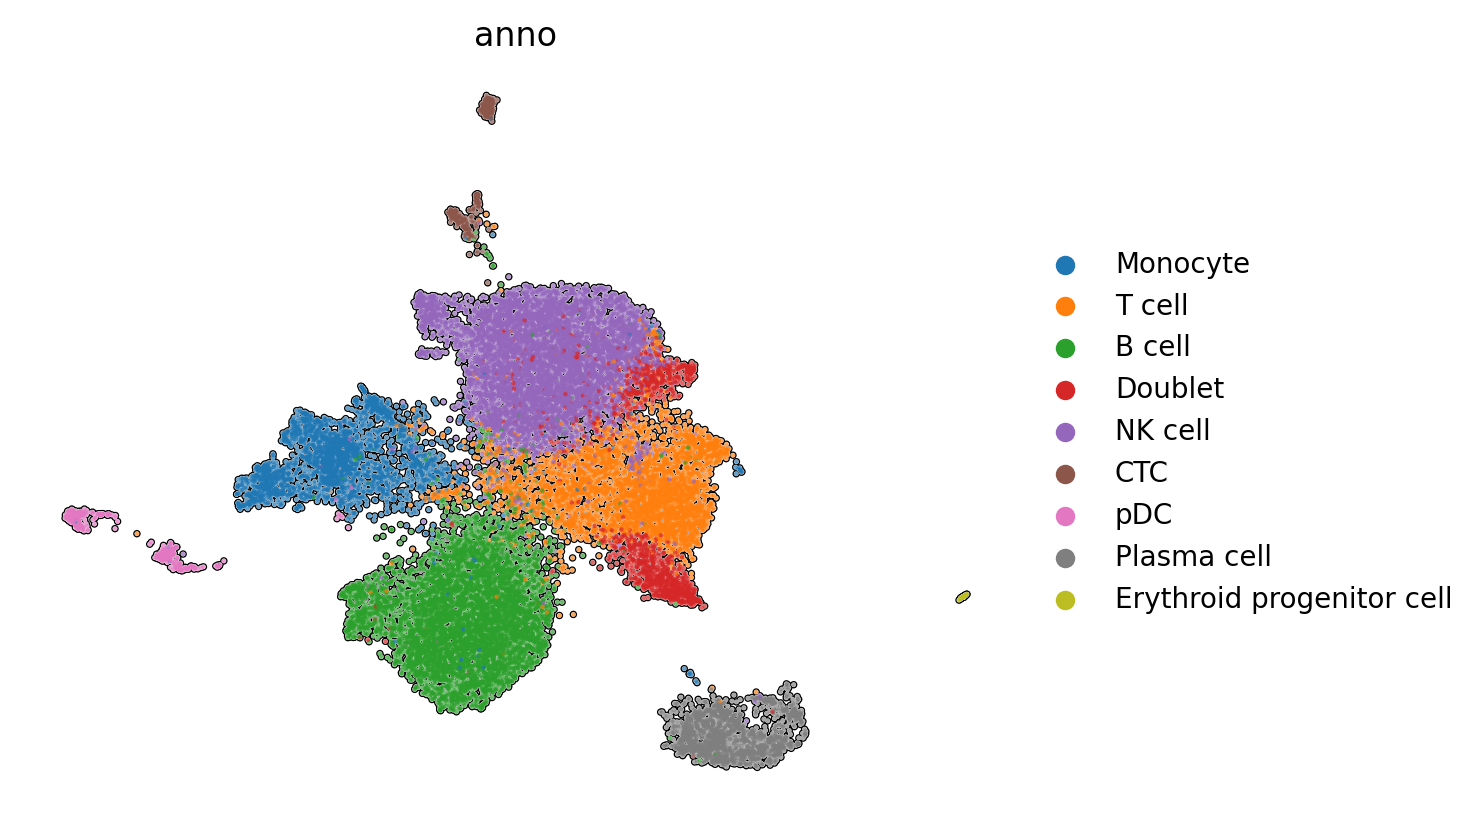

In [47]:
sc.pl.umap(ctc, color='anno', add_outline=True, size=10, frameon=False)

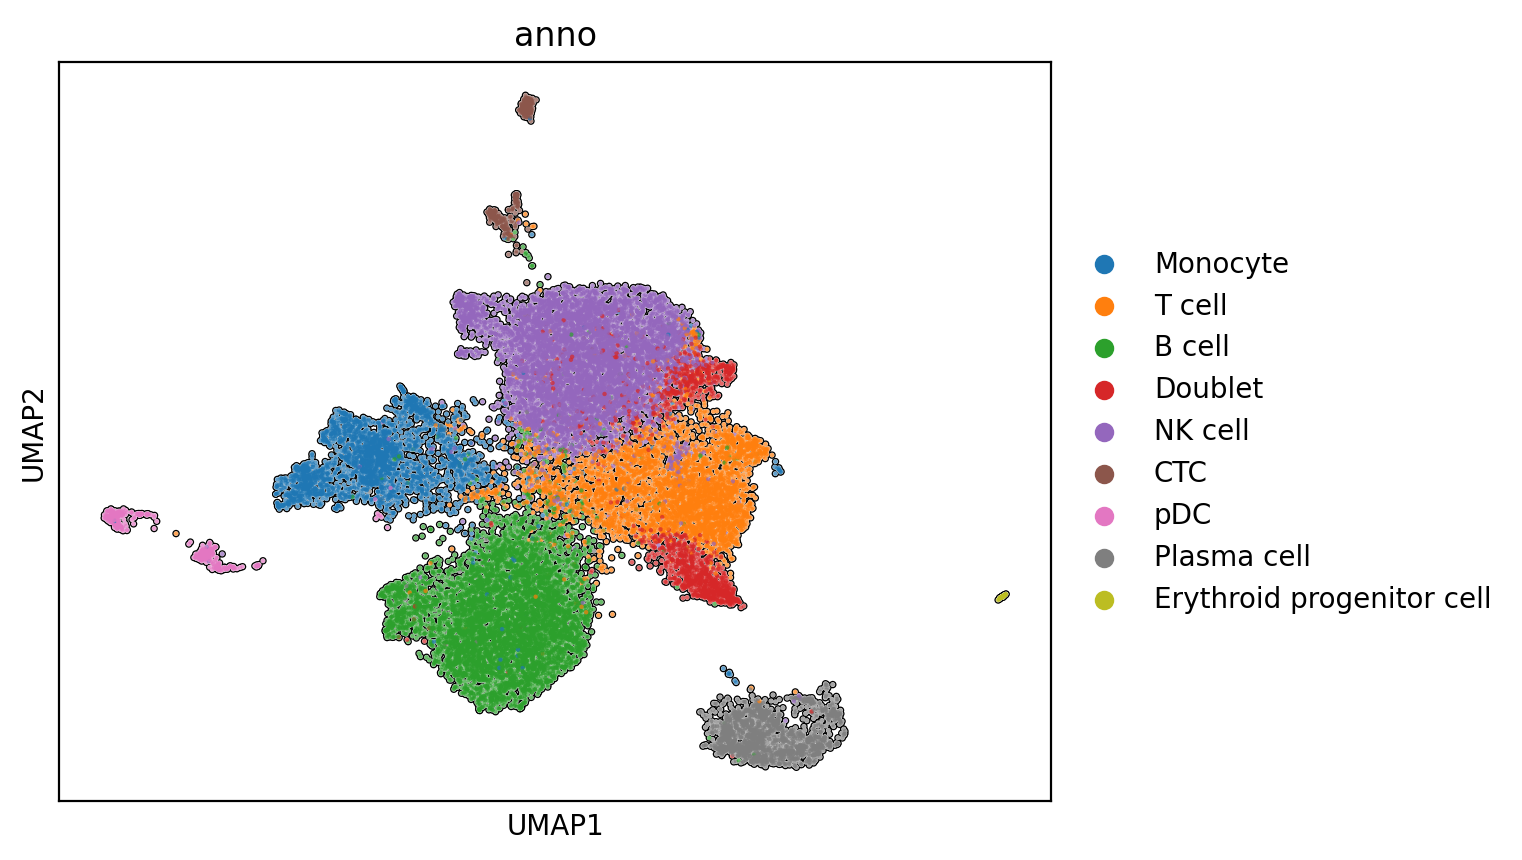

In [48]:
sc.pl.umap(ctc, color='anno', add_outline=True, size=10, frameon=True)

In [51]:
anno_mapping = {
    "0": "Monocyte", # 	A100A9, CYRIA, DUSP1, FCN1, LYZ2, PSAP, S100A8, VCAN, WARS
    "1": "T cell", # BCL11B, CAMK IV, FYB, IL-7R, LEF1, TCF7, TMEM66
    "2": "B cell", # BCL11A, CD79A, GNG7, PAX5, POU2AF1
    "3": "B cell", #  BACH2, BCL11A, CD22, GNG7, NIBAN3, PAX5
    "4": "Doublet", # CD2, CX3CR1, FCG3RA, FGFBP2, GNLY, GZMA, GZMB, KLRB1, NKG7, PRF1
    "5": "NK cell", # CD247, GNLY, GZMA, GZMB, KLRB1, KLRD1, KLRF1, NKG7, PRF1, SPON2
    "6": "T cell", # BCL11B, CAMK IV, CD6, FYB, IL-7R, LEF1, LEPROTL1, PIK3IP1, TCF7, TMEM66
    "7": "NK cell", # CD247, GNLY, KLRD1, KLRF1, NKG7, PRF1, SPON2
    "8": "CTC_1", # CDH13, COL4A2 	(epi)EMCN, LDB2, VWF
    "9": "CTC_2", # COL1A1
    "10": "Monocyte", # A100A9, C5AR1, DUSP1, ITGAX, S100A8
    "11": "pDC_1", # AML3, BCL11A, TCF4
    "12": "Plasma cell", # AML3, APP, BCL11A, CCDC50, CLE4C, IRF8, NRP1, TCF4, TSPAN13
    "13": "pDC_2", # AML3, APP, BCL11A, CCDC50, CLE4C, IRF8, NRP1, TCF4, TSPAN13
    "14": "Erythroid progenitor cell" # CA1, HBA1, HBA2, HBB, HBG1, HBG2, SLC25A37, SNCA
}

ctc.obs['anno_for_umap'] = ctc.obs['leiden'].replace(anno_mapping)

/tmp/ipykernel_1853762/113695053.py:19: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  ctc.obs['anno_for_umap'] = ctc.obs['leiden'].replace(anno_mapping)


In [52]:
umap_coords = pd.DataFrame(ctc.obsm["X_umap"], columns=["UMAP_1", "UMAP_2"])
umap_coords["cell_id"] = ctc.obs.index  # 添加细胞ID
umap_coords["anno"] = ctc.obs["anno_for_umap"].tolist()

In [53]:
umap_coords.to_csv('umap_coordinate.csv', index=None)

In [57]:
del ctc.obs['anno_for_umap']

In [58]:
ctc.write_h5ad('/home/share/huadjyin/home/ouyangkang/project/ctc/data/precessed/ctc_with_anno.h5ad')

In [2]:
ctc = sc.read_h5ad('/home/share/huadjyin/home/ouyangkang/project/ctc/data/precessed/ctc_with_anno.h5ad')

In [3]:
ctc = ctc[ctc.obs[ctc.obs['anno'] != 'Doublet'].index, :]

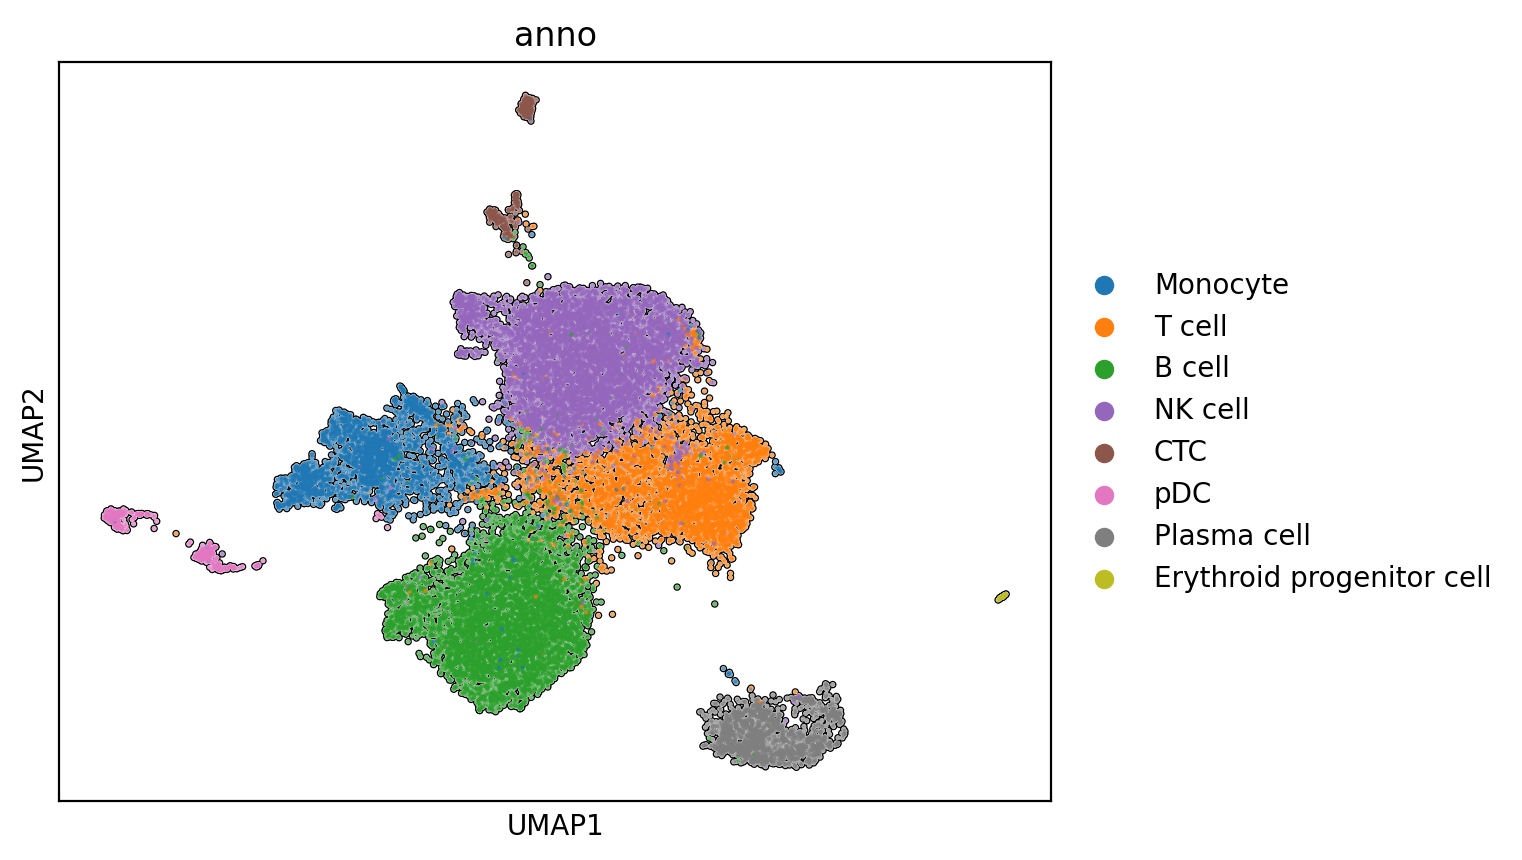

In [84]:
sc.pl.umap(ctc, color='anno', add_outline=True, size=10, frameon=True)

### PTPRC ratio

In [10]:
m_index = ctc.obs[ctc.obs['anno'] == 'CTC'].index
m_adata = ctc[m_index, :]

In [11]:
m_adata

View of AnnData object with n_obs × n_vars = 352 × 36472
    obs: 'total_counts', 'pct_counts_mt', 'pct_counts_rb', 'pct_counts_hb', 'n_genes', 'doublet_score', 'chip_id', 'patient_info', 'phage_info', '_scvi_batch', '_scvi_labels', 'leiden', 'anno', 'chip_color'
    var: 'n_cells', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'highly_variable_nbatches'
    uns: '_scvi_manager_uuid', '_scvi_uuid', 'anno_colors', 'chip_id_colors', 'hvg', 'leiden', 'leiden_colors', 'log1p', 'neighbors', 'umap'
    obsm: 'X_scVI', 'X_umap', '_scvi_extra_categorical_covs', '_scvi_extra_continuous_covs'
    layers: 'counts'
    obsp: 'connectivities', 'distances'

In [12]:
ptprc_ratio = m_adata[:, 'PTPRC'].layers['counts'] / m_adata.layers['counts'].sum(axis=1)

In [13]:
m_adata.obs['ptprc'] = ptprc_ratio.todense()

/tmp/ipykernel_2316916/1315521328.py:1: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  m_adata.obs['ptprc'] = ptprc_ratio.todense()


In [14]:
m_adata = m_adata[m_adata.obs[m_adata.obs['ptprc'] <= 0.0001].index, :]

In [15]:
num_chip_df = pd.crosstab(m_adata.obs['chip_id'], m_adata.obs['anno'])

In [16]:
true_ctc_index = m_adata.obs_names

In [17]:
ctc.obs['anno_ctc'] = np.where((ctc.obs['anno'] == 'CTC') & (ctc.obs.index.isin(true_ctc_index)), 'True CTC',
                              np.where((ctc.obs['anno'] == 'CTC') & (~ctc.obs.index.isin(true_ctc_index)), 'False CTC', ctc.obs['anno']))

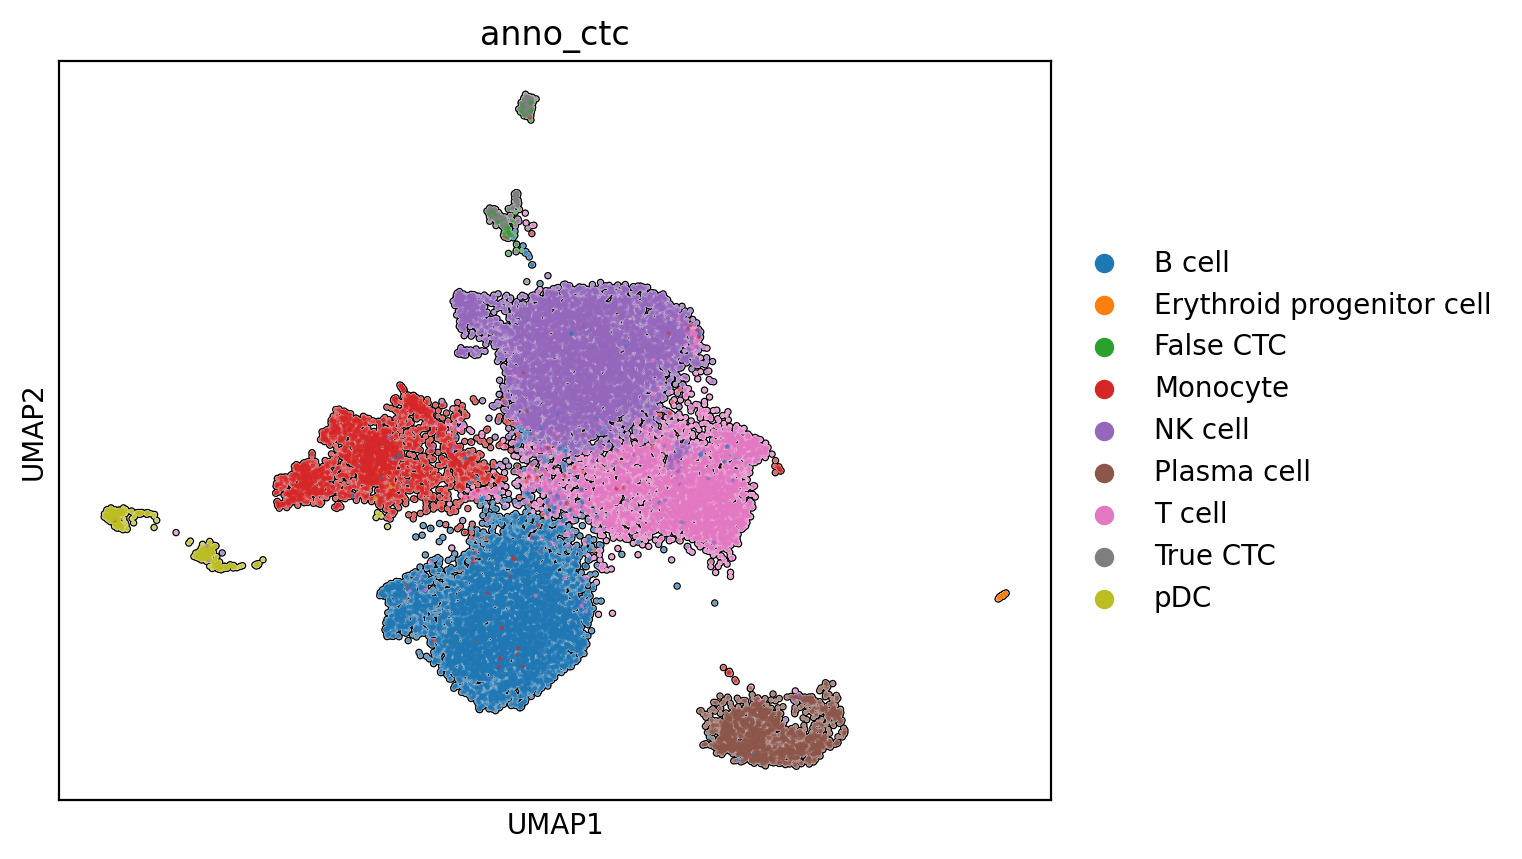

In [18]:
sc.pl.umap(ctc, color='anno_ctc', add_outline=True, size=10, frameon=True)

In [19]:
ctc.write_h5ad('/home/share/huadjyin/home/ouyangkang/project/ctc/data/precessed/ctc_with_anno.h5ad')

## plot

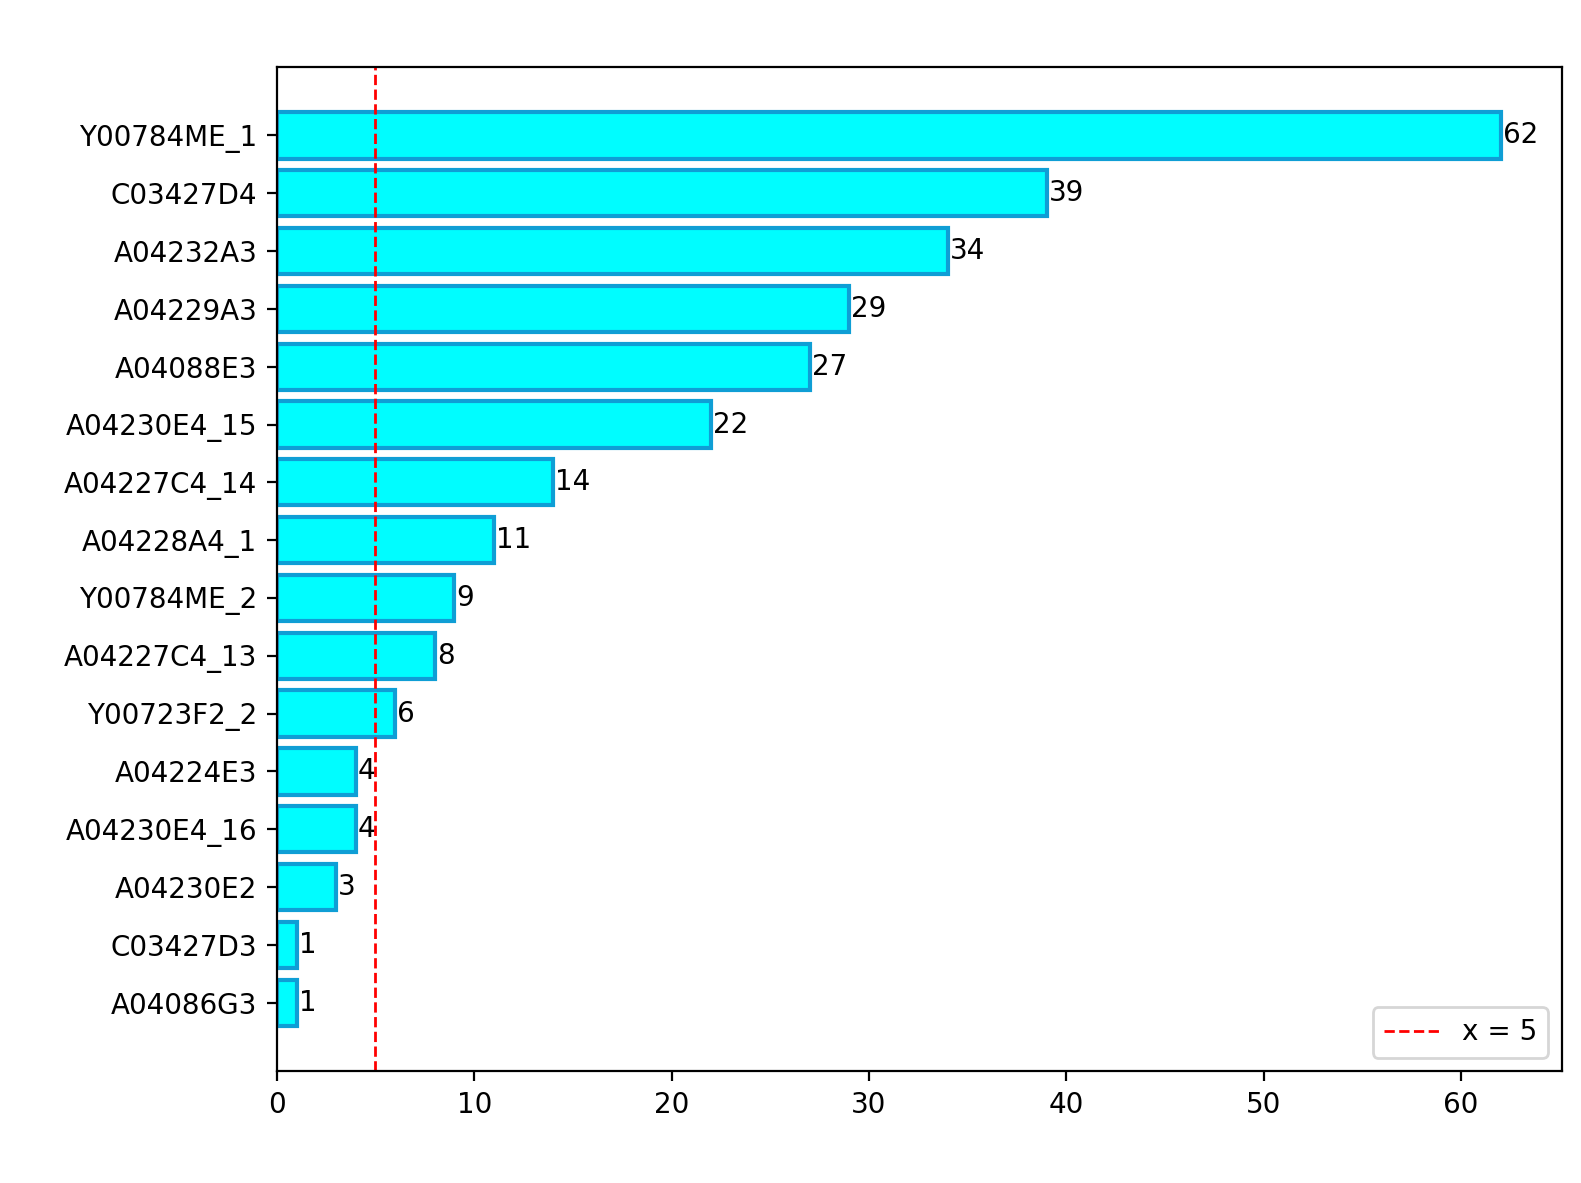

In [136]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.style.use('default')

fill_color = '#00FDFF'
border_color = '#0F9ED5'

ax = plt.barh(num_chip_df.index, num_chip_df['CTC'], color=fill_color, edgecolor=border_color, linewidth=1.5)

# 添加参考线
plt.axvline(x=5, color='red', linestyle='--', linewidth=1, label='x = 5')

# 添加数值标签
for i, v in enumerate(num_chip_df['CTC']):
    plt.text(v + 0.1, i, f"{v:.0f}", va='center')

# 美化坐标轴
plt.xlabel("CTC Count", fontsize=12, color='white')
plt.ylabel("Chip ID", fontsize=12, color='white')
plt.title("CTC Count per Chip", fontsize=14, color='white')

plt.grid(False)
# 添加标签、图例
plt.xlabel("CTC Count")
plt.ylabel("Chip ID")
plt.legend()
plt.tight_layout()
plt.show()

In [158]:
cell_type_num = pd.crosstab(ctc.obs['chip_id'], ctc.obs['anno_ctc'])
cell_type_ratio = cell_type_num.div(cell_type_num.sum(axis=1), axis=0)
cell_type_ratio.to_csv('cell_type_ratio.csv')

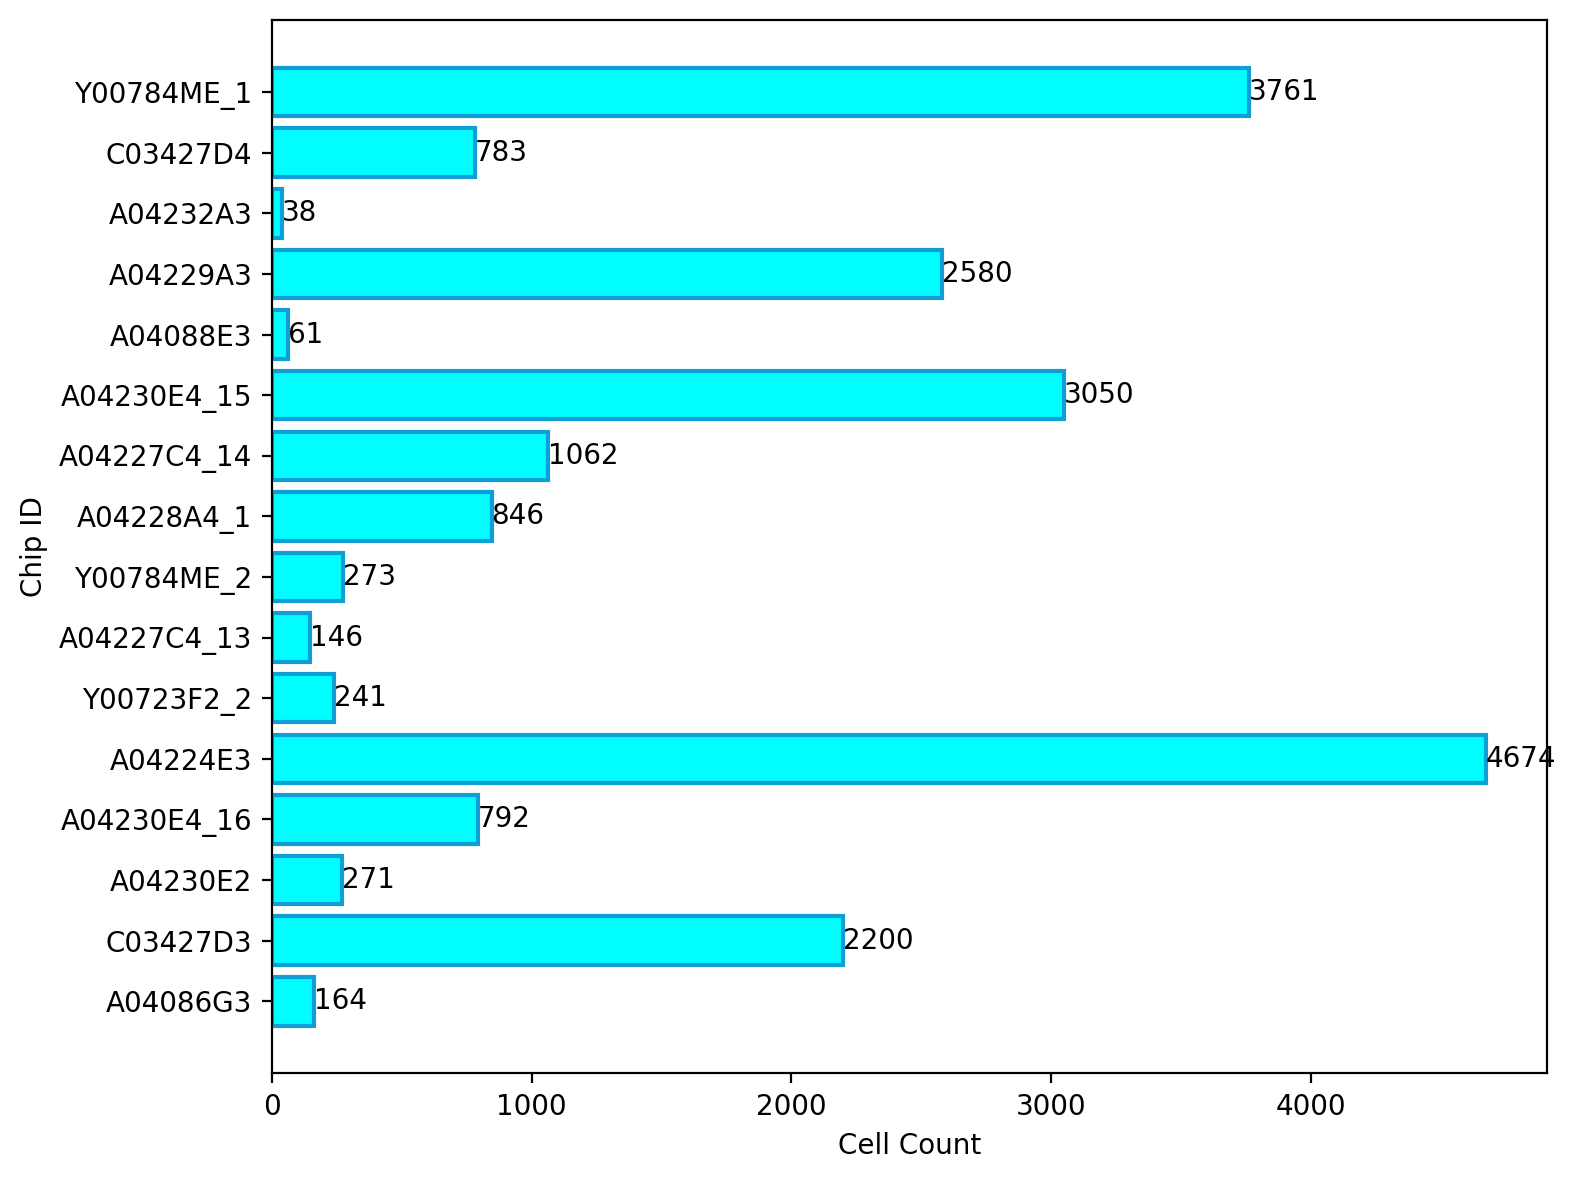

In [157]:
chip_id_total = pd.DataFrame(cell_type_num.sum(axis=1))
chip_id_total = chip_id_total.loc[num_chip_df.index]

plt.figure(figsize=(8, 6))

fill_color = '#00FDFF'
border_color = '#0F9ED5'

ax = plt.barh(chip_id_total.index, chip_id_total[0], color=fill_color, edgecolor=border_color, linewidth=1.5)

for i, v in enumerate(chip_id_total[0]):
    plt.text(v + 0.1, i, f"{v:.0f}", va='center')

plt.xlabel("Cell Count")
plt.ylabel("Chip ID")
plt.tight_layout()
plt.show()

In [4]:
chip_color = {
    "A04086G2": "#F8766D",
    "A04086G3": "#E88526",
    "A04088E3": "#D39200",
    "A04224E3": "#B79F00",
    "A04227C4_13": "#93AA00",
    "A04227C4_14": "#5EB300", 
    "A04228A4_1": "#00BA38",
    "A04229A3": "#00BF74",
    "A04230E2": "#00C19F",
    "A04230E4_15": "#00BFC4",
    "A04230E4_16": "#00B9E3",
    "A04232A3": "#00ADFA",
    "C03427D3": "#619CFF",
    "C03427D4": "#AE87FF",
    "Y00723F2_1": "#DB72FB",
    "Y00723F2_2": "#F564E3", 
    "Y00784ME_1": "#FF61C3",
    "Y00784ME_2": "#FF699C"
}

ctc.obs['chip_color'] = ctc.obs['chip_id'].replace(chip_color)

/tmp/ipykernel_2316916/272801180.py:22: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  ctc.obs['chip_color'] = ctc.obs['chip_id'].replace(chip_color)
/tmp/ipykernel_2316916/272801180.py:22: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  ctc.obs['chip_color'] = ctc.obs['chip_id'].replace(chip_color)


In [5]:
chip_order = chip_color.keys()
ctc.obs['chip_id'] = ctc.obs['chip_id'].cat.reorder_categories(chip_order)

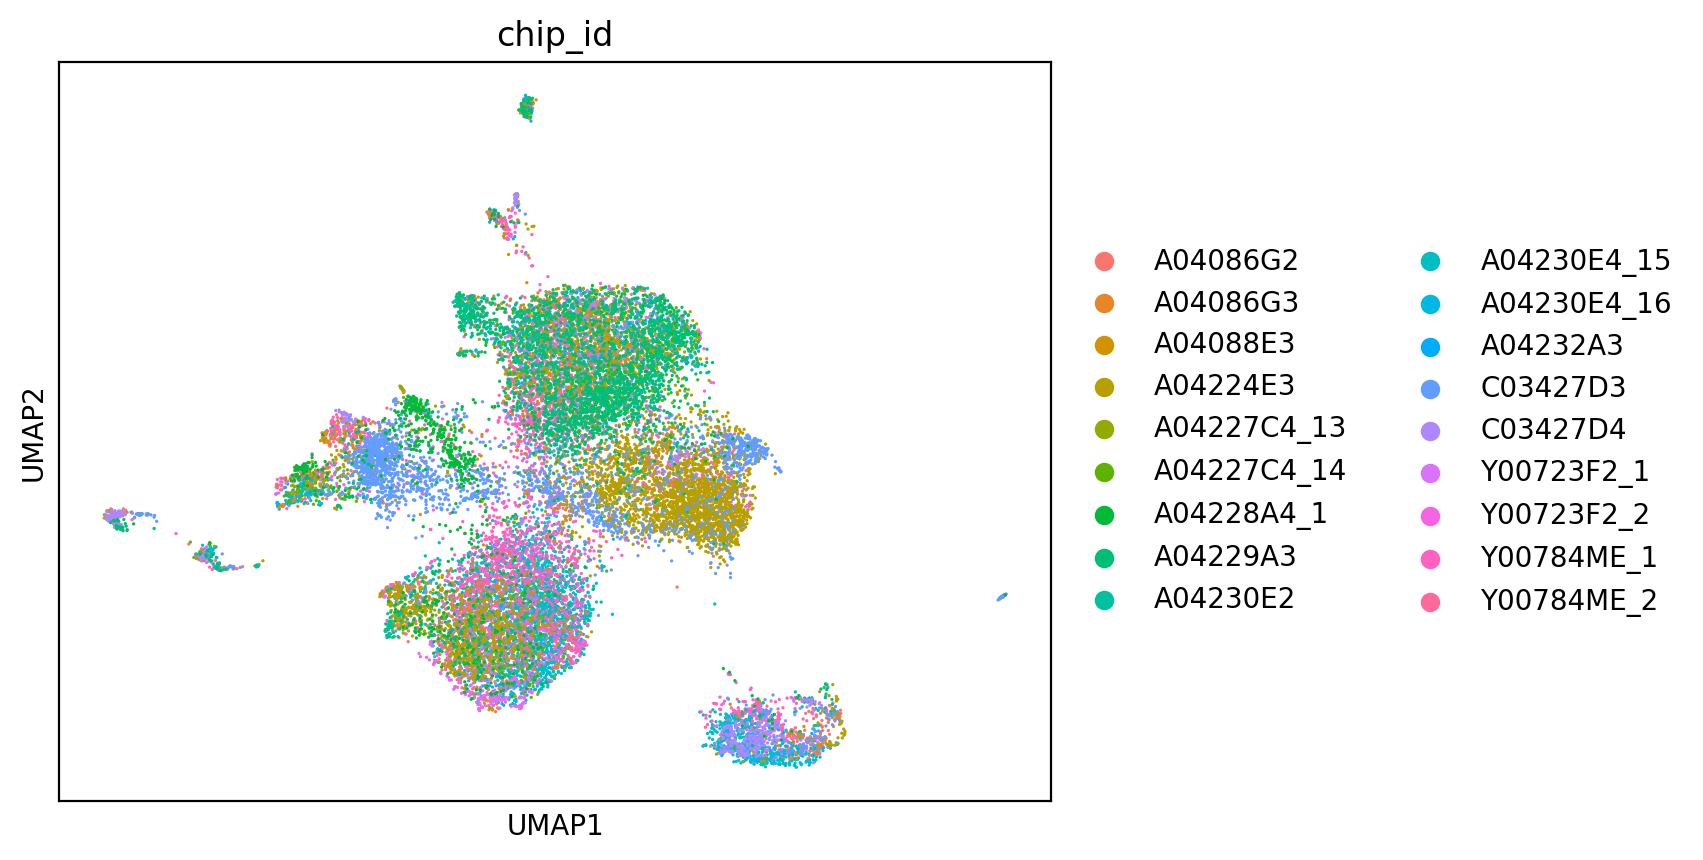

In [8]:
import matplotlib.pyplot as plt
sc.pl.umap(ctc, color=['chip_id'], palette=chip_color, show=False)
plt.savefig('Batch_correct_UMAP.pdf', dpi=300, bbox_inches='tight')

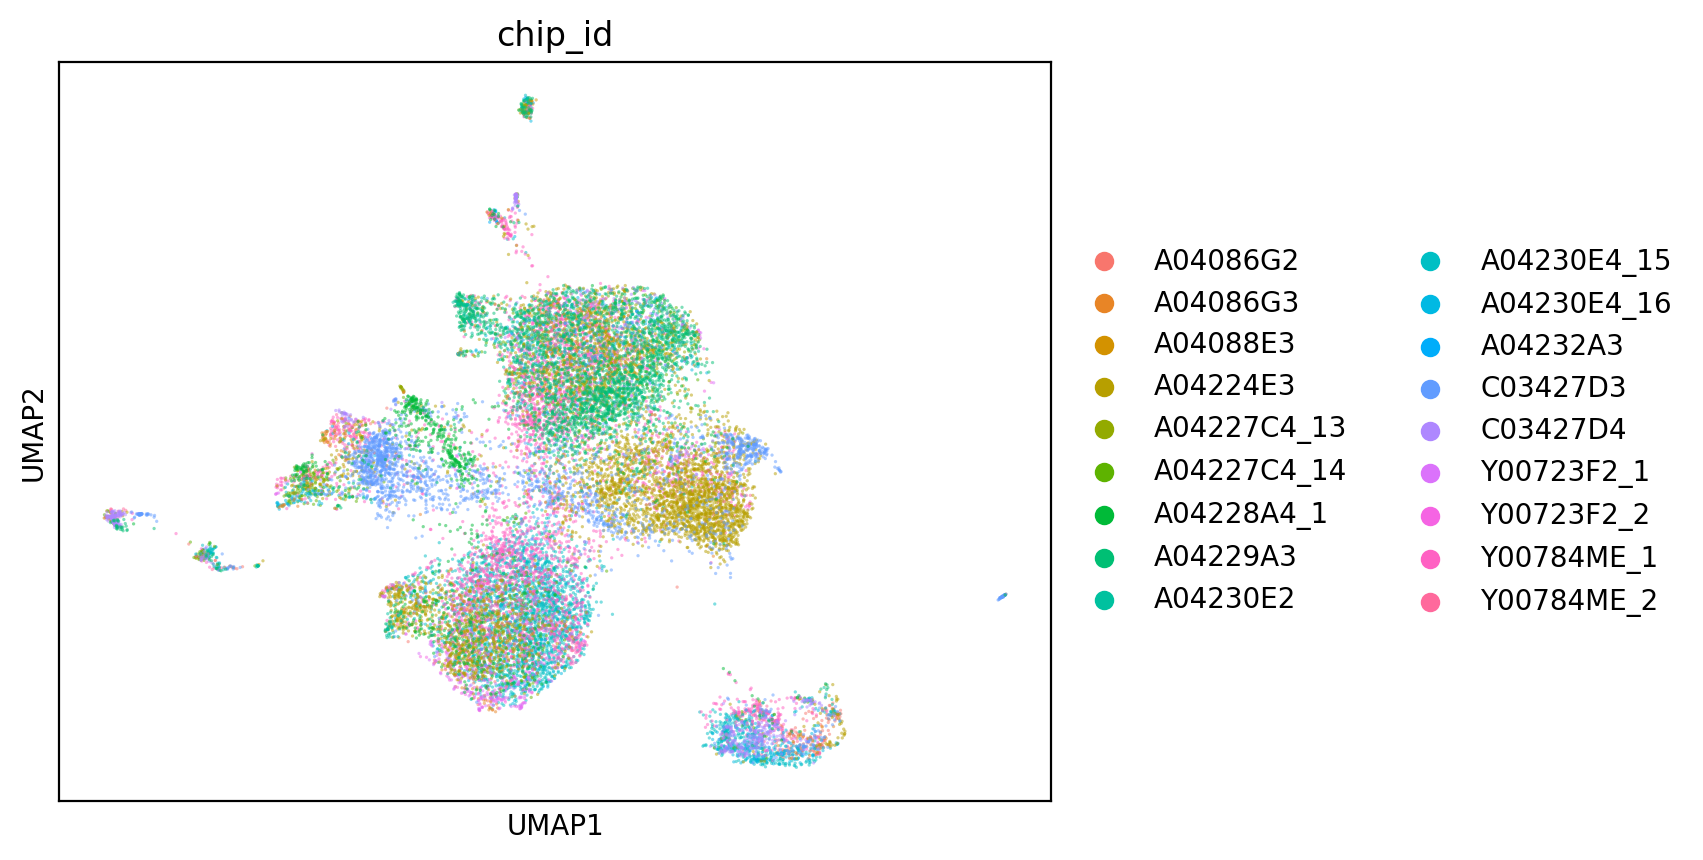

In [9]:
sc.pl.embedding(
    ctc,
    basis="umap",
    color="chip_id",
    palette=chip_color,
    alpha=0.5,       # ✅ 设置透明度
    show=False
)
plt.savefig('Batch_correct_UMAP.pdf', dpi=300, bbox_inches='tight')

In [170]:
ctc.obs['phage_info'].unique()

['S2', 'V2', 'V0', 'None']
Categories (4, object): ['S2', 'V2', 'V0', 'None']

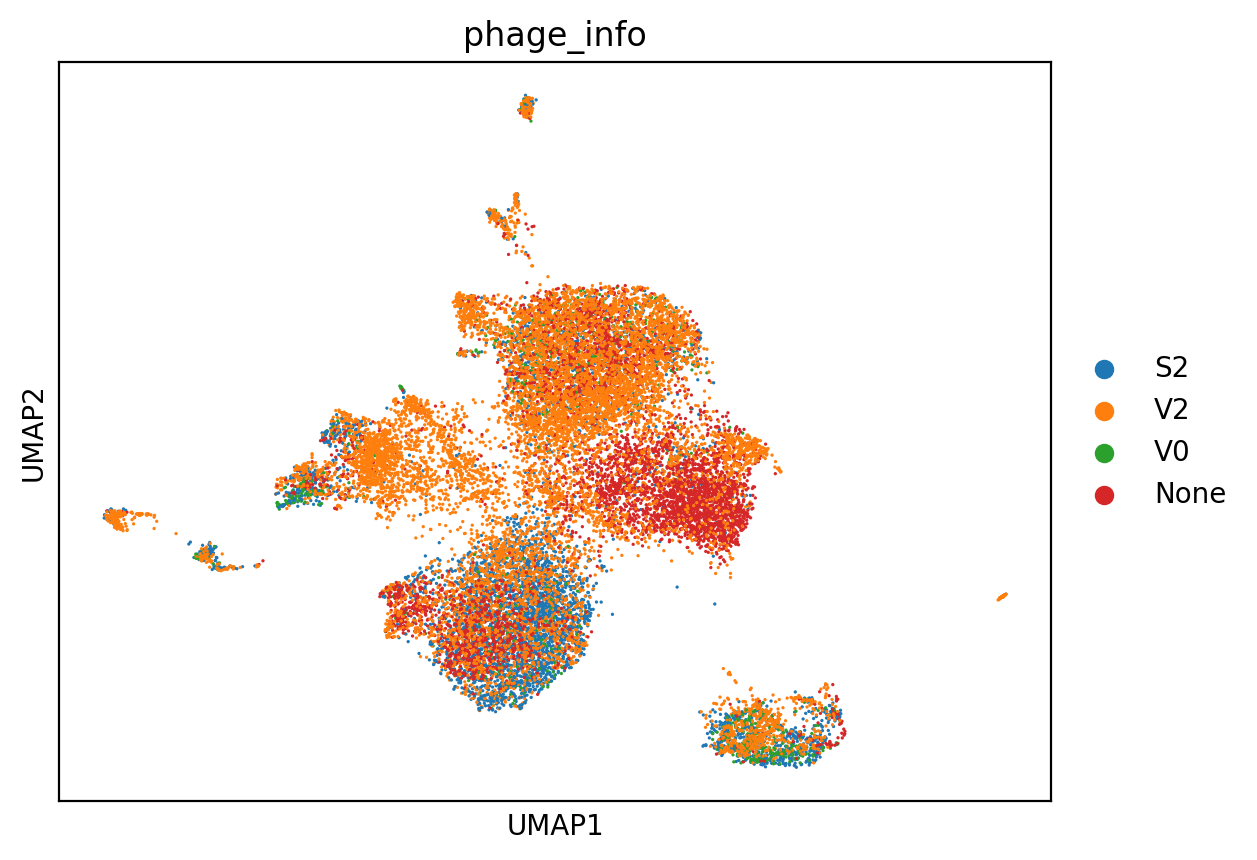

In [172]:
sc.pl.umap(ctc, color=['phage_info'], show=False)
plt.savefig('Phage_info_UMAP.pdf', dpi=300, bbox_inches='tight')